## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
import warnings
import import_ipynb
from Utility import *

warnings.simplefilter(action='ignore', category=FutureWarning)
import random

warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

importing Jupyter notebook from Utility.ipynb


 ### Read Music Data by artists

In [2]:
data = pd.read_csv(r"datasets/data_by_artist.csv")
data.head()

,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5
2,1,7,0.856571,"""Fiddler On The Roof” Motion Picture Chorus",0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0
3,1,27,0.884926,"""Fiddler On The Roof” Motion Picture Orchestra",0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0
4,1,7,0.510714,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5


We only need **'valence', 'artists', 'count', 'popularity'** fields from the dataset. Hence, retrieving those fields and saving it in a csv file named as "artist_data.csv"


In [3]:
artist_data = data[['valence', 'artists', 'count', 'popularity']]
artist_data.to_csv('datasets/artist_data.csv')

 ### Read Music Data from spotify dataset

In [4]:
p = 0.02  # to randomly select 1% of the rows
df_playlist_spotify = pd.read_csv(r"datasets/spotify_dataset.csv", error_bad_lines=False, warn_bad_lines=False,
                                  skiprows=lambda i: i > 0 and random.random() > p)
df_playlist_spotify.head()

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Tom Petty And The Heartbreakers,American Girl,IOW 2012
1,07f0fc3be95dcd878966b1f9572ff670,Blockhead,Redacted - Instrumental,Chill out
2,07f0fc3be95dcd878966b1f9572ff670,Apparat,Sweet Unrest,Chill out
3,07f0fc3be95dcd878966b1f9572ff670,Mogwai,This Messiah Needs Watching,Chill out
4,07f0fc3be95dcd878966b1f9572ff670,Wolfgang Amadeus Mozart,"Requiem In D Minor, Sequentia: Dies Irae",Classique


### Clean up column names
1. remove extra quotes 
2. update column names by removing **name** from column name
3. remove extra white spaces

In [5]:
df_playlist_spotify.columns = df_playlist_spotify.columns.str.replace('"', '')
df_playlist_spotify.columns = df_playlist_spotify.columns.str.replace('name', '')
df_playlist_spotify.columns = df_playlist_spotify.columns.str.replace(' ', '')
df_playlist_spotify.columns

Index(['user_id', 'artist', 'track', 'playlist'], dtype='object')

### For recommender system, we are only keeping the artists with frequency higher than 50

In [6]:
df_playlist = df_playlist_spotify.groupby('artist').filter(lambda x: len(x) >= 50)

### Only keep users with at least 10 unique artists in their playlists in order to reduce the impact of cold start problem

In [7]:
df_playlist = df_playlist[df_playlist.groupby('user_id').artist.transform('nunique') >= 10]

### Group by to get the frequency count for each user and artist (number of times that an artist has appeared in playlists created by a user)

In [8]:
size = lambda x: len(x)
df_freq = df_playlist.groupby(['user_id', 'artist']).agg('size').reset_index().rename(columns={0: 'freq'})[
    ['user_id', 'artist', 'freq']].sort_values(['freq'], ascending=False)
df_freq.head()

,user_id,artist,freq
6998,26b51e580277e131f87e4c7ee4c0887a,Vitamin String Quartet,63
43215,fa849dabeb14a2800ad5130907fc5018,Peggy Lee,52
30769,b1d4116e7cf150ae7d77413620f5f571,Wolfgang Amadeus Mozart,44
11388,414050deadb38aafd8d4ad22ca634055,Vitamin String Quartet,42
43173,fa849dabeb14a2800ad5130907fc5018,Frank Sinatra,37


### Create a DF for artists and add artist id

In [9]:
df_artist = pd.DataFrame(df_freq["artist"].unique())
df_artist = df_artist.reset_index()
df_artist = df_artist.rename(columns={'index': 'artist_id', 0: 'artist'})
df_artist.head()

,artist_id,artist
0,0,Vitamin String Quartet
1,1,Peggy Lee
2,2,Wolfgang Amadeus Mozart
3,3,Frank Sinatra
4,4,Jamey Aebersold Play-A-Long


## Hybrid Song Recommendation 

It is a recommendation system which is combination of the content and collaborative filtering method.  By using content and collaborative-based methods to generate predictions separately and then combining the prediction, we can generate more accurate recommendations and also reduces the problem of cold start.

1. **PCA_algorithm**: to reduce the dimensionality (in our case number of components is 2) within a dataset while still retaining as much information as possible.

2. **KMeans_with_PCA_algorithm**: algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping clusters. 
    Based on the values of the Within Cluster Sum of Squares (WCSS) and an approach known as the Elbow method, we made a decision about how many clusters we’d like to keep.In our case, we have kept number of cluster as 50.

3. we have then created a new data frame df_segm_pca_kmeans. It allows us to add in the values of the separate components to our segmentation data set. The components’ scores are stored in the ‘scores P C A’ variable. Let’s label them com1 and com2.

4. **filter_based_on_segment**: filters songs that belong to particulat cluster segment.

5. **filter_based_on_cluster_centroid**: filters songs based on closet distance of song and centroid

6. returns list of top n artists, where n is set as 10 in our case

In [10]:
def recommend_artists(artist,  n=10):    
    """
    Recommends songs based on a list of previous songs that a user has listened to.
    """
    song_embedding = PCA_algorithm(artist_data)
    kmeans_pca, centroids = KMeans_with_PCA_algorithm(song_embedding,50)

    df_segm_pca_kmeans = pd.concat([artist_data.reset_index(drop=True), pd.DataFrame(song_embedding)], axis=1)
    df_segm_pca_kmeans.columns.values[-2:] = ['com1', 'com2']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

    #get segment value of artist
    segment_val = df_segm_pca_kmeans[df_segm_pca_kmeans['artists'] == artist]['Segment K-means PCA'].values[0]

    filtered_data_per_segment = filter_based_on_segment(df_segm_pca_kmeans, segment_val,'artists', 'valence')

    rec_artists = filter_based_on_cluster_centroid(kmeans_pca, filtered_data_per_segment, segment_val, artist_data)

    #recommend top n artists
    return rec_artists.head(n)['artists'].tolist()

**recommend_artist_and_songs:** Finds list of songs and artists  based on the selected artist name 
Recommends Top N artist with their song(s). In  our case, we have recommended top 10 songs

In [11]:
def recommend_artist_and_songs(artist, n_songs=10):
    # get recommended artists
    recommended_artists = pd.DataFrame({
            'artist' : recommend_artists(artist, n_songs)
        })
    recommend_songs_list = pd.DataFrame(columns = ['artist', 'songs'])

    # get songs per artist
    for i in range(len(recommended_artists)):
        artist = recommended_artists.loc[i, "artist"]
        recommend_song = pd.DataFrame({
            'artist' : artist,
            'songs' :get_song_from_artist(artist, 1)
        })
        recommend_songs_list = recommend_songs_list.append(recommend_song, ignore_index = True)
    return  recommend_songs_list

**pass favorite artist name and no of recommended artist/song you want to listen and it gives you the list with n recommended artist with 1 songs per artist**

In [12]:
recommended_artist_and_songs = recommend_artist_and_songs('Ella Fitzgerald',10)
display(recommended_artist_and_songs)

,artist,songs
0,Ella Fitzgerald,'Deed I Do
1,Lata Mangeshkar,Aa Ab Laut Chalen
2,Dean Martin,'Til I Find You
3,The Beach Boys,"""Cassius"" Love Vs. ""Sonny"" Wilson - Remastered..."
4,The Rolling Stones,(I Can't Get No) Satisfaction - (Original Sing...
5,Ludwig van Beethoven,"12 Variations on ""Ein Mädchen oder Weibchen"", ..."
6,Bob Dylan,(Quinn the Eskimo) The Mighty Quinn - Live at ...
7,Fleetwood Mac,Albatross - 2018 Master
8,Wolfgang Amadeus Mozart,Adagio II
9,Irina Salkow,Kapitel 1 - Der Page und die Herzogin


## Circle graph to show recommended songs

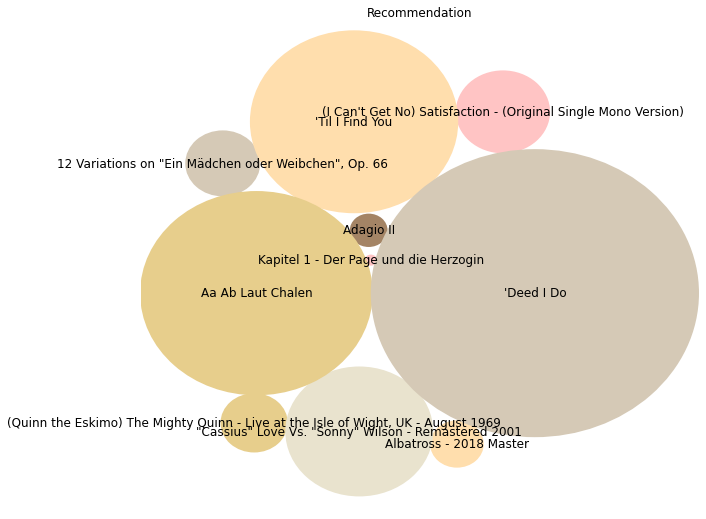

In [13]:
circlify_vizualization(recommended_artist_and_songs['songs'])

## Circle graph to show recommended Artists

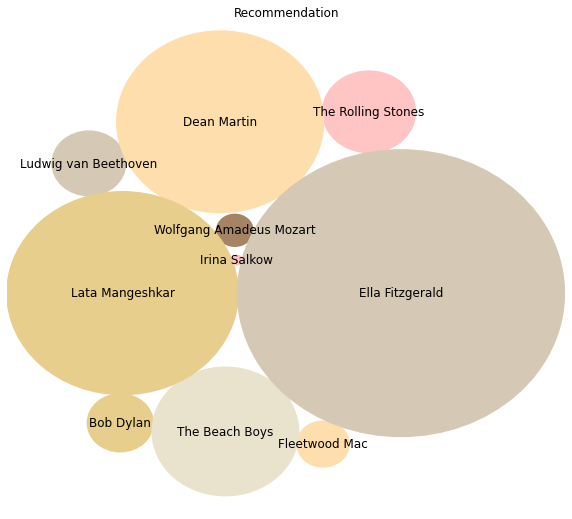

In [14]:
circlify_vizualization(recommended_artist_and_songs['artist'])